In [251]:
import pandas as pd
from datetime import datetime, time
import numpy as np
import requests, zipfile, io, os, re, csv, warnings
import matplotlib.pyplot as plt
import preprocessing.constants as constants
import features.common.zones as zones
from IPython.display import clear_output
from preprocessing.taxi import get_parsed_df as get_parsed_taxi_df
from preprocessing.bike import get_parsed_df as get_parsed_bike_df
from preprocessing.common import clean_column_names
# Ignore the warnings about storing incompatible data types HDFStore
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

# Dataframe Loading/Cleaning/Features

## Taxi Data
Since these downloads take a long time, do NOT reset all run times if you are not on localhost when it asks you to! It will wipe all downloaded files, and you'll have to download them again!

Note that the features are added in here as well for efficiency.

In [252]:
taxi_store = pd.HDFStore(constants.TAXI_DATA_PATH + '/dataframes.h5')

In [253]:
# IGNORE MEMORY LIMIT WARNINGS! The data is garbage collected every time the function exits for each year.

df_taxi_2013 = get_parsed_taxi_df("2013", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_2014 = get_parsed_taxi_df("2014", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_2015 = get_parsed_taxi_df("2015", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_2016 = get_parsed_taxi_df("2016", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_2017 = get_parsed_taxi_df("2017", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_2018 = get_parsed_taxi_df("2018", taxi_store).sort_values(by='pickup_datetime', kind='mergesort')
df_taxi_all = [df_taxi_2013, df_taxi_2014, df_taxi_2015, df_taxi_2016, df_taxi_2017, df_taxi_2018]

clear_output()

In [254]:
# Just like an open file, it must be closed to release the file lock.
taxi_store.close()

## Citi Bike Data
Note that the features are added in here as well for efficiency.

In [255]:
bike_store = pd.HDFStore(constants.BIKE_DATA_PATH + '/dataframes.h5')

In [256]:
df_bike_2013 = get_parsed_bike_df('2013', bike_store)
df_bike_2014 = get_parsed_bike_df('2014', bike_store)
df_bike_2015 = get_parsed_bike_df('2015', bike_store)
df_bike_2016 = get_parsed_bike_df('2016', bike_store)
df_bike_2017 = get_parsed_bike_df('2017', bike_store)
df_bike_2018 = get_parsed_bike_df('2018', bike_store)
df_bike_all = [df_bike_2013, df_bike_2014, df_bike_2015, df_bike_2016, df_bike_2017, df_bike_2018]

clear_output()

In [257]:
bike_store.close()

## Features Not Yet Migrated
This still needs to be moved to the external py files of `features/bike.py` and `features/taxi.py` file - optimizations can be done first before moving it, perhaps?

### Zones / Neighborhoods
Define NYC taxi zone as a feature for all df

In [258]:
def add_zones(df): #ridiculously slow, sorry
    df['zone_from'] = np.vectorize(zones.lookup_id)(df.pickup_longitude,df.pickup_latitude)
    df['zone_to'] = np.vectorize(zones.lookup_id)(df.dropoff_longitude,df.dropoff_latitude)
    df['zone_from_to'] = np.vectorize(zones.from_to)(df.pickup_longitude,df.pickup_latitude,df.dropoff_longitude,df.dropoff_latitude)

#Popualte Taxi Zone Columns
for df in [df_taxi_2013,df_taxi_2014,df_taxi_2015,df_taxi_2016]: #taxi 2017/2018 use a different system in place of lon/lat
  add_zones(df)
  df.dropna(subset=['zone_from','zone_to','zone_from_to'],inplace=True)


In [259]:
def add_zones(df):
    df['zone_from'] = np.vectorize(zones.lookup_id)(df.start_station_longitude, df.start_station_latitude)
    df['zone_to'] = np.vectorize(zones.lookup_id)(df.end_station_longitude, df.end_station_latitude)
    df['zone_from_to'] = np.vectorize(zones.from_to)(df.start_station_longitude, df.start_station_latitude, df.end_station_longitude, df.end_station_latitude)

#Populate Taxi Zone Columns for citibike
for df in df_bike_all:
    add_zones(df)
    df.dropna(subset=['zone_from','zone_to','zone_from_to'],inplace=True)


In [122]:
#attempt at adding zone_from_to to 2017 and 2018 taxi dataframes.  Results in a high # of nan vals?

#def from_to_zid(from_id, to_id):
#    try:
#        return zones.ZONES_DIC[str(float(from_id))].name + ' to ' + zones.ZONES_DIC[str(float(to_id))].name
#    except:
#        return np.nan
#
#def add_zones(df):
#    df['zone_from'] = df['PULocationID']
#    df['zone_to'] = df['DOLocationID']
#    df['zone_from_to'] = np.vectorize(from_to_zid)(df.zone_from, df.zone_to)
#
#for df in [df_taxi_2017, df_taxi_2018]:
#    add_zones(df)
#    df.dropna(subset=['zone_from', 'zone_to', 'zone_from_to'], inplace=True)

# Analysis

## Exploratory Data Analysis

### Trip Distance

In [260]:
# df_taxi_2015 contains some weirdly high trip distance outliers.

df_taxi_2015[df_taxi_2015.trip_distance > 500].count()

VendorID                 21
pickup_datetime          21
dropoff_datetime         21
passenger_count          21
trip_distance            21
pickup_longitude         21
pickup_latitude          21
RateCodeID               21
store_and_fwd_flag       21
dropoff_longitude        21
dropoff_latitude         21
payment_type             21
fare_amount              21
extra                    21
mta_tax                  21
tip_amount               21
tolls_amount             21
improvement_surcharge    21
total_amount             21
tripduration             21
zone_from                21
zone_to                  21
zone_from_to             21
dtype: int64

bike mean:  1.1761168440183003
taxi mean:  2.9681836433167406


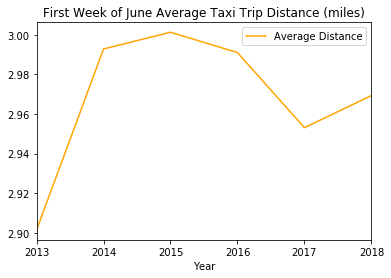

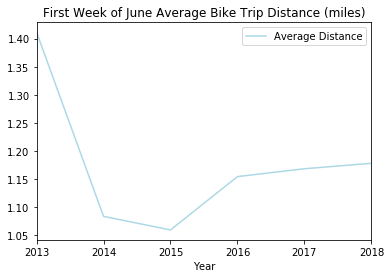

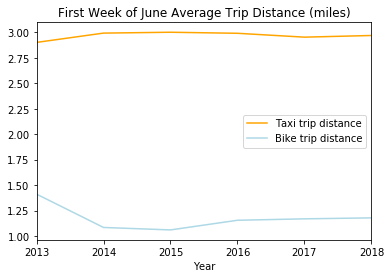

In [261]:
avg_trip_distance_bike = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()
     ]})

print('bike mean: ',np.mean([df_bike_2013.trip_distance.mean(),
         df_bike_2014.trip_distance.mean(),
         df_bike_2015.trip_distance.mean(),
         df_bike_2016.trip_distance.mean(),
         df_bike_2017.trip_distance.mean(),
         df_bike_2018.trip_distance.mean()]))

avg_trip_distance_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average Distance': [
         df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()
     ]})

print('taxi mean: ',np.mean([df_taxi_2013.trip_distance.mean(),
         df_taxi_2014.trip_distance.mean(),
         df_taxi_2015[df_taxi_2015.trip_distance < 500].trip_distance.mean(), # remove weirdly high trip distances...
         df_taxi_2016.trip_distance.mean(),
         df_taxi_2017.trip_distance.mean(),
         df_taxi_2018.trip_distance.mean()]))

avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Taxi Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Bike Trip Distance (miles)', color='lightblue')

_ = avg_trip_distance_taxi.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', color='orange')
avg_trip_distance_bike.plot(
    kind='line', x='Year', y='Average Distance', title='First Week of June Average Trip Distance (miles)', ax=_, color='lightblue')
_.legend(['Taxi trip distance', 'Bike trip distance'])

### Trip Duration

bike trip duration mean:  1213.1575192188793
taxi trip duration mean: 931.8789673962391


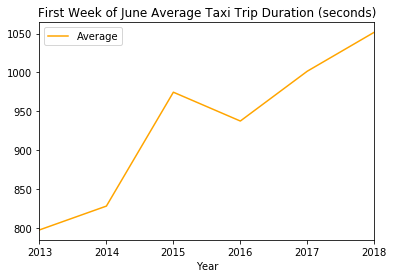

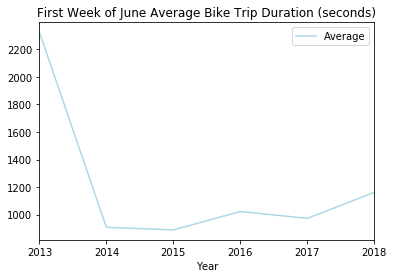

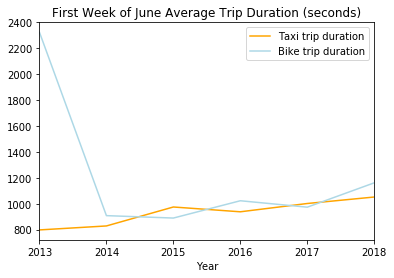

In [262]:
# Create average trip duration dataframes and plot

avg_trip_duration_bike = pd.DataFrame(
    {'Year': constants.YEARS, 
     'Average': [
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] 
    })
print('bike trip duration mean: ',np.mean([
        df_bike_2013.tripduration.mean(),
        df_bike_2014.tripduration.mean(),
        df_bike_2015.tripduration.mean(),
        df_bike_2016.tripduration.mean(),
        df_bike_2017.tripduration.mean(),
        df_bike_2018.tripduration.mean()] ))

avg_trip_duration_taxi = pd.DataFrame(
    {'Year': constants.YEARS,
     'Average': [
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]
    })

print('taxi trip duration mean:', np.mean([
         df_taxi_2013.tripduration.mean(),
         df_taxi_2014.tripduration.mean(),
         df_taxi_2015.tripduration.mean(),
         df_taxi_2016.tripduration.mean(),
         df_taxi_2017.tripduration.mean(),
         df_taxi_2018.tripduration.mean()]))

avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Taxi Trip Duration (seconds)', color='orange')

avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Bike Trip Duration (seconds)', color='lightblue')

_ = avg_trip_duration_taxi.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', color='orange')
avg_trip_duration_bike.plot(
    kind='line', x='Year', y='Average', title='First Week of June Average Trip Duration (seconds)', ax=_, color='lightblue')
_.legend(['Taxi trip duration', 'Bike trip duration'])


#fig.savefig('trip_duration.jpg')

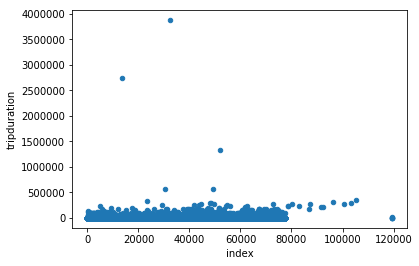

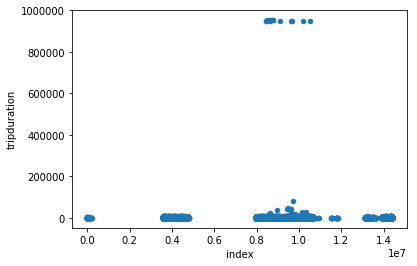

In [263]:
# quick scatter plot--exposes some weird outliers.  
# CitiBike has some >1000 hour trips
# Cabs have some negative time durations

df_bike_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

df_taxi_2013.reset_index().plot(kind='scatter', x='index', y='tripduration')

### CitiBike rider age

In [264]:
# had to avoid 2014 here, as there are some issues with the birthdate field in that dataframe. Will clean.
# yo people in their 40s love citibikes

citi_avg_age = []

citi_avg_age.append(df_bike_2013["birth_year"].mean())
citi_avg_age.append("NaN")
citi_avg_age.append(df_bike_2015["birth_year"].mean())
citi_avg_age.append(df_bike_2016["birth_year"].mean())
citi_avg_age.append(df_bike_2017["birth_year"].mean())
citi_avg_age.append(df_bike_2018["birth_year"].mean())

print(citi_avg_age)

[1973.7237548828125, 'NaN', 1976.08154296875, 1977.1600341796875, 1979.1080322265625, 1980.276123046875]


### Number of Trips

In [265]:
df_bike_2013.tail(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trip_distance,zone_from,zone_to,zone_from_to
119305,176,2013-06-05 08:41:29,2013-06-05 08:44:25,376.0,John St & William St,40.708622,-74.007225,376.0,John St & William St,40.708622,-74.007225,17000,Subscriber,1985.0,2,0.0,87.0,87.0,Financial District North to Financial District...
119307,2258,2013-06-05 16:33:41,2013-06-05 17:11:19,376.0,John St & William St,40.708622,-74.007225,376.0,John St & William St,40.708622,-74.007225,18283,Subscriber,1976.0,1,0.0,87.0,87.0,Financial District North to Financial District...
119308,802,2013-06-05 18:13:02,2013-06-05 18:26:24,376.0,John St & William St,40.708622,-74.007225,376.0,John St & William St,40.708622,-74.007225,16131,Subscriber,1980.0,1,0.0,87.0,87.0,Financial District North to Financial District...
119310,9104,2013-06-05 18:30:34,2013-06-05 21:02:18,376.0,John St & William St,40.708622,-74.007225,376.0,John St & William St,40.708622,-74.007225,20052,Subscriber,1975.0,1,0.0,87.0,87.0,Financial District North to Financial District...
119312,3999,2013-06-06 06:43:00,2013-06-06 07:49:39,376.0,John St & William St,40.708622,-74.007225,376.0,John St & William St,40.708622,-74.007225,20005,Subscriber,1961.0,1,0.0,87.0,87.0,Financial District North to Financial District...


In [266]:
# Using .loc everywhere here to try to remove the SettingsWithCopyWarning, but still happens unfortunately. No idea how to fix
df_taxi_2013.loc[:,'day'] = df_taxi_2013.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2014.loc[:,'day'] = df_taxi_2014.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2015.loc[:,'day'] = df_taxi_2015.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2016.loc[:,'day'] = df_taxi_2016.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2017.loc[:,'day'] = df_taxi_2017.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))
df_taxi_2018.loc[:,'day'] = df_taxi_2018.loc[:,'pickup_datetime'].map(lambda date: date.strftime('%d (%a)'))

df_bike_2013.loc[:,'day'] = df_bike_2013.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2014.loc[:,'day'] = df_bike_2014.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2015.loc[:,'day'] = df_bike_2015.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2016.loc[:,'day'] = df_bike_2016.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2017.loc[:,'day'] = df_bike_2017.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))
df_bike_2018.loc[:,'day'] = df_bike_2018.loc[:,'starttime'].map(lambda date: date.strftime('%d (%a)'))


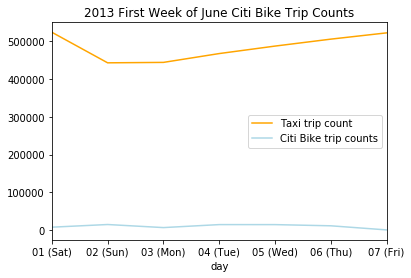

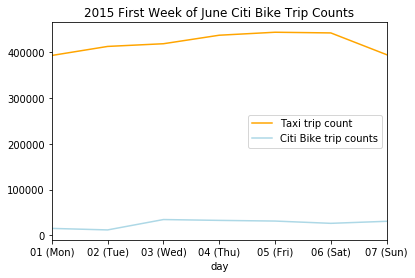

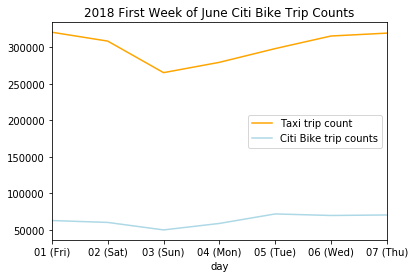

In [267]:
first_plot = df_taxi_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Taxi Trip Counts', color='orange')
df_bike_2013.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2013 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Taxi Trip Counts', color='orange')
df_bike_2015.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2015 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

first_plot = df_taxi_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Taxi Trip Counts', color='orange')
df_bike_2018.groupby(by='day').size().reset_index(name='counts').plot(kind='line', x='day', y='counts', title='2018 First Week of June Citi Bike Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip counts'])

In [268]:
# Make new data frames for yearly trip counts, and graph them

df_taxi_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_taxi_2013.groupby(by='day').size().sum(),
    df_taxi_2014.groupby(by='day').size().sum(),
    df_taxi_2015.groupby(by='day').size().sum(),
    df_taxi_2016.groupby(by='day').size().sum(),
    df_taxi_2017.groupby(by='day').size().sum(),
    df_taxi_2018.groupby(by='day').size().sum(),
]})

df_bike_trip_counts = pd.DataFrame({'Year': constants.YEARS, 'Count': [
    df_bike_2013.groupby(by='day').size().sum(),
    df_bike_2014.groupby(by='day').size().sum(),
    df_bike_2015.groupby(by='day').size().sum(),
    df_bike_2016.groupby(by='day').size().sum(),
    df_bike_2017.groupby(by='day').size().sum(),
    df_bike_2018.groupby(by='day').size().sum(),
]})

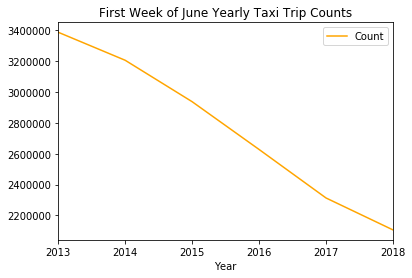

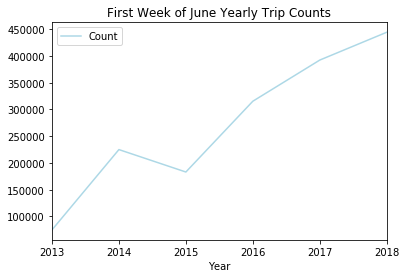

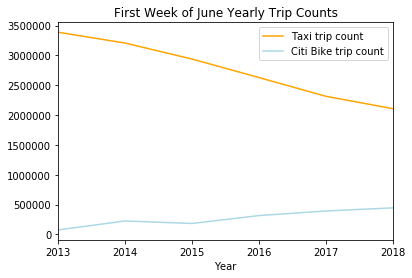

In [269]:
df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', color='lightblue') 

first_plot = df_taxi_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Taxi Trip Counts', color='orange')
df_bike_trip_counts.plot(kind='line', x='Year', y='Count', title='First Week of June Yearly Trip Counts', ax=first_plot, color='lightblue')
first_plot.legend(['Taxi trip count', 'Citi Bike trip count'])

#### Popular Routes

In [270]:
print('10 most frequent inter-zone trips by Taxi')
df_taxi_2016[df_taxi_2016.zone_from != df_taxi_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Taxi


Central Park to Midtown Center         40256
Midtown Center to Central Park         38315
Clinton East to Central Park           31024
Central Park to Clinton East           27010
East Chelsea to Clinton East           24702
Lincoln Square East to Central Park    20623
Clinton East to East Chelsea           20514
Central Park to Midtown East           20486
Midtown East to Central Park           20455
Clinton East to Midtown Center         19502
Name: zone_from_to, dtype: int64

In [271]:
print('10 most frequent inter-zone trips by Bike')
df_bike_2016[df_bike_2016.zone_from != df_bike_2016.zone_to].zone_from_to.value_counts()[0:10]

10 most frequent inter-zone trips by Bike


Clinton East to East Chelsea               3050
East Chelsea to Clinton East               2756
Central Park to Clinton East               2104
Greenwich Village North to East Village    1946
East Village to Greenwich Village North    1929
Clinton East to Central Park               1833
Clinton East to Midtown Center             1817
Greenwich Village North to East Chelsea    1814
Central Park to Midtown Center             1811
East Village to Alphabet City              1763
Name: zone_from_to, dtype: int64

In [272]:
print('10 most frequent trips by Bike')
df_bike_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Bike


Central Park to Central Park                          12764
East Chelsea to East Chelsea                           6972
Clinton East to Clinton East                           3859
Clinton East to East Chelsea                           3050
East Chelsea to Clinton East                           2756
East Village to East Village                           2466
Brooklyn Heights to Brooklyn Heights                   2109
Central Park to Clinton East                           2104
Greenwich Village North to Greenwich Village North     2053
Greenwich Village North to East Village                1946
Name: zone_from_to, dtype: int64

In [273]:
print('10 most frequent trips by Taxi')
df_taxi_2016.zone_from_to.value_counts()[0:10]

10 most frequent trips by Taxi


Central Park to Central Park           233726
Central Park to Midtown Center          40256
Midtown Center to Central Park          38315
East Chelsea to East Chelsea            31784
Clinton East to Central Park            31024
Central Park to Clinton East            27010
East Chelsea to Clinton East            24702
Clinton East to Clinton East            24084
Lincoln Square East to Central Park     20623
Clinton East to East Chelsea            20514
Name: zone_from_to, dtype: int64

In [274]:
print('Most common trips to Manhattanville (City College) Zone by Taxi 2016\n')

zone_from = df_taxi_2016[df_taxi_2016.zone_to == 152.0].zone_from.value_counts().index[0:10]
for zone_id in zone_from:
    z = constants.ZONES_DIC[str(zone_id)]
    print(z.name,'to Manhattanville')

Most common trips to Manhattanville (City College) Zone by Taxi 2016

Central Park to Manhattanville
Bloomingdale to Manhattanville
Clinton East to Manhattanville
Central Harlem North to Manhattanville
Central Harlem to Manhattanville
East Chelsea to Manhattanville
Manhattanville to Manhattanville
Lincoln Square East to Manhattanville
East Harlem North to Manhattanville
Midtown Center to Manhattanville


## REGRESSION CLEANING

In [335]:
#create df copies so if I fuck up I can just re-run this cell

df_b16 = df_bike_2016.copy()
df_t16 = df_taxi_2016.copy()

In [336]:
#convert weird day string to int value

df_t16.loc[df_t16.day == "01 (Wed)", "day"] = 4
df_t16.loc[df_t16.day == "02 (Thu)", "day"] = 5
df_t16.loc[df_t16.day == "03 (Fri)", "day"] = 6
df_t16.loc[df_t16.day == "04 (Sat)", "day"] = 7
df_t16.loc[df_t16.day == "05 (Sun)", "day"] = 1
df_t16.loc[df_t16.day == "06 (Mon)", "day"] = 2
df_t16.loc[df_t16.day == "07 (Tue)", "day"] = 3

In [337]:
#convert weird day string to int value

df_b16.loc[df_b16.day == "01 (Wed)", "day"] = 4
df_b16.loc[df_b16.day == "02 (Thu)", "day"] = 5
df_b16.loc[df_b16.day == "03 (Fri)", "day"] = 6
df_b16.loc[df_b16.day == "04 (Sat)", "day"] = 7
df_b16.loc[df_b16.day == "05 (Sun)", "day"] = 1
df_b16.loc[df_b16.day == "06 (Mon)", "day"] = 2
df_b16.loc[df_b16.day == "07 (Tue)", "day"] = 3

In [338]:
#extract time from datetime

df_b16.starttime = df_b16.starttime.apply(lambda x: x.time())
df_b16.stoptime = df_b16.stoptime.apply(lambda x: x.time())

df_t16['starttime'] = df_t16.pickup_datetime.apply(lambda x: x.time())
df_t16['stoptime'] = df_t16.dropoff_datetime.apply(lambda x: x.time())

In [339]:
def make_times():
    times = []
    for i in range(0, 24):
        times.append(time(i, 0, 0))
        times.append(time(i, 30, 0))
    return times

times = make_times()

In [340]:
def time_to_val(t, times):
    for index, time in enumerate(times):
        if (t < time):
            return (index - 1)
    return 47

In [341]:
#bin times in 30 minutes intervals to int vals

df_b16.starttime = df_b16.starttime.apply(time_to_val, times=times)
df_t16.starttime = df_t16.starttime.apply(time_to_val, times=times)

df_b16.stoptime = df_b16.stoptime.apply(time_to_val, times=times)
df_t16.stoptime = df_t16.stoptime.apply(time_to_val, times=times)

In [342]:
#find intersection of most common routes between bike and taxi

t_16_keys = df_t16[df_t16.zone_from != df_t16.zone_to].zone_from_to.value_counts()[0:100].keys()
b_16_keys = df_b16[df_b16.zone_from != df_b16.zone_to].zone_from_to.value_counts()[0:100].keys()

route_set = set(t_16_keys & b_16_keys)

In [343]:
def set_null(route, route_set):
    if route in route_set:
        return route
    return np.nan

In [345]:
# if row does not contain a value from route_set, set from_to to nan

df_t16['from_to'] = df_t16.zone_from_to.apply(set_null, route_set=route_set)
df_b16['from_to'] = df_b16.zone_from_to.apply(set_null, route_set=route_set)

In [349]:
# drop nans

df_t16.dropna(subset=['from_to'], inplace=True)
df_b16.dropna(subset=['from_to'], inplace=True)

In [351]:
route_list = list(route_set)

In [354]:
# convert from_to string to integer

df_t16.from_to = df_t16.from_to.apply(lambda x: route_list.index(x))
df_b16.from_to = df_b16.from_to.apply(lambda x: route_list.index(x))

In [374]:
# remove some columns

df_b16 = df_b16[['from_to', 'day', 'starttime', 'stoptime', 'tripduration', 'trip_distance']]
df_t16 = df_t16[['from_to', 'day', 'starttime', 'stoptime', 'tripduration', 'trip_distance']]


# create new b_t feature: 0 bike, 1 taxi
df_b16['b_t'] = 0
df_t16['b_t'] = 1

df_t16.head()

,from_to,day,starttime,stoptime,tripduration,trip_distance,b_t
95251,13,4,0,0,223.0,0.90,1
95253,6,4,0,0,179.0,0.76,1
95255,13,4,0,0,223.0,0.98,1
95258,21,4,0,0,368.0,2.26,1
95260,0,4,0,0,415.0,1.61,1


In [367]:
# concat the two dataframes

frames = [df_b16, df_t16]
df_bt16 = pd.concat(frames)

In [371]:
df_bt16.head()

,from_to,day,starttime,stoptime,tripduration,trip_distance,b_t
5,4,4,0,0,946.0,1.711888,0
12,41,4,0,1,1795.0,2.833989,0
20,46,4,0,0,1154.0,0.725555,0
25,15,4,0,0,1362.0,1.975443,0
26,29,4,0,0,741.0,1.569602,0
